In [1]:
import sys
import warnings
import os
if not sys.warnoptions:
    warnings.simplefilter('ignore')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from math import floor
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
from copy import deepcopy as copy
from torch.utils.data import DataLoader, TensorDataset
sns.set()
from get_rr import goodness_of_fit, get_rr
def seed_torch(seed=1122):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
seed_torch(1122)

In [78]:
class GetData:
    def __init__(self, batch_size=20, n=5):
        """
        简单地读取数据
        """
        path1 = '../数据预处理/化学原料33支股票新版.csv'
        path2 = '../数据预处理/钢铁行业34支股票新版.csv'
        path3 = '../数据预处理/种植业19支股票新版.csv'
        sh2 = pd.read_csv(path1)
        sh02 = pd.read_csv(path2)
        sh2 = pd.read_csv(path3)
        #sh02 = pd.concat([sh1,sh2,sh3],axis=0,ignore_index=True)
        sent = ['neg_num', 'pos_num', 'bias']
        xinxi = ['quality_val']
        wenben = ['avg_sentence','avg_stroke','four_word','function_ratio','n_ratio',
                 'nine_stroke','no_text','sen_per_para','sum_para','word_max','word_mean']
        sh02.drop(labels=xinxi,axis=1,inplace=True)
        self.data = sh02
        self.batch_size = batch_size
        self.n = n
        self.features = []
        self.labels = []
        
    def preprocess(self):
        self.data = self.data.fillna(0)
        self.data = self.data.set_index('date')
        self.close_min = self.data['close'].min()
        self.close_max = self.data["close"].max()
        self.data = self.data.apply(lambda x: (x - min(x)) / (max(x) - min(x)))
        self.data = self.data.fillna(0)
        self.indnums = len(list(self.data['code'].unique()))
        for i in list(self.data['code'].unique()):
            data = self.data[self.data['code']==i]
            data.drop(labels=['code'],axis=1,inplace=True)
            self.split(data)
            
    def split(self, data):
        n = self.n
        feature = [
            data.iloc[i: i + n].values.tolist()
            for i in range(len(data) - n + 2)
            if i + n < len(data)
        ]
        label = [
            data.close.values[i + n]
            for i in range(len(data) - n + 2)
            if i + n < len(data)
        ]
        #print(len(label))
        self.features.append(feature)
        self.labels.append(label)
        
    def split_all(self):
        train_x = []
        test_x = []
        train_y = []
        test_y = []
        self.preprocess()
        # 一支股票的数据被分成了725条，前百分之九十用来训练，后百分之十测试
        num = int(725 * 0.9)
        print("num:"+str(num))
        print("len(features):"+str(len(self.features)))
        print("len(feature):"+str(len(self.features[2])))
        # 按照时间顺序构建训练集和测试集
        for i in range(len(self.features)):
            for j in range(len(self.features[i])):
                if j < num:
                    train_x.append(self.features[i][j])
                    train_y.append(self.labels[i][j])
                else:
                    test_x.append(self.features[i][j])
                    test_y.append(self.labels[i][j])
#         # 把训练集打乱
#         cc = list(zip(train_x, train_y))
#         random.shuffle(cc)
#         train_x[:], train_y[:] = zip(*cc)
        print("len(train_x):"+str(len(train_x)))
        print("len(train_y):"+str(len(train_y)))
        print("len(test_x):"+str(len(test_x)))
        print("len(test_y):"+str(len(test_y)))
        return train_x, test_x, train_y, test_y

In [68]:
class GetData2:
    def __init__(self, batch_size=20, n=5):
        """
        简单地读取数据
        """
        path1 = '../数据预处理/化学原料33支股票新版.csv'
        path2 = '../数据预处理/钢铁行业34支股票新版.csv'
        path3 = '../数据预处理/种植业19支股票新版.csv'
        sh1 = pd.read_csv(path1)
#         print('化学原料：'+str(list(sh1['code'].unique())))
#         print(str(len(list(sh1['code'].unique()))))
        sh2 = pd.read_csv(path2)
#         print('钢铁：'+str(list(sh2['code'].unique())))
#         print(str(len(list(sh2['code'].unique()))))
        sh3 = pd.read_csv(path3)
#         print('种植业：'+str(list(sh3['code'].unique())))
#         print(str(len(list(sh3['code'].unique()))))
        sent = ['neg_num', 'pos_num', 'bias']
        xinxi = ['quality_val']
        wenben = ['avg_sentence','avg_stroke','four_word','function_ratio','n_ratio',
                 'nine_stroke','no_text','sen_per_para','sum_para','word_max','word_mean']
        sh02 = pd.concat([sh1,sh2,sh3],axis=0,ignore_index=True)
        sh02.drop(labels=xinxi,axis=1,inplace=True)
        self.data = sh02
        self.batch_size = batch_size
        self.n = n
        self.features_train = []
        self.labels_train = []
        self.features_test = []
        self.labels_test = []
        self.features = []
        self.labels = []
        
    def preprocess(self):
        self.data = self.data.fillna(0)
        self.data = self.data.set_index('date')
        self.close_min = self.data['close'].min()
        self.close_max = self.data["close"].max()
        self.data = self.data.apply(lambda x: (x - min(x)) / (max(x) - min(x)))
        self.data = self.data.fillna(0)
        self.indnums = len(list(self.data['code'].unique()))
        for i in list(self.data['code'].unique()):
            data = self.data[self.data['code']==i]
            data.drop(labels=['code'],axis=1,inplace=True)
            self.split(data)
            
    def split(self, data):
        n = self.n
        feature = [
            data.iloc[i: i + n].values.tolist()
            for i in range(len(data) - n + 2)
            if i + n < len(data)
        ]
        label = [
            data.close.values[i + n]
            for i in range(len(data) - n + 2)
            if i + n < len(data)
        ]
        #print(len(label))
        self.features.append(feature)
        self.labels.append(label)
        
    def split_all(self):
        train_x = []
        test_x = []
        train_y = []
        test_y = []
        self.preprocess()
        num = int(725 * 0.9)
        print("num:"+str(num))
        print("len(features):"+str(len(self.features)))
        print("len(feature):"+str(len(self.features[2])))
        for i in range(len(self.features)):
            for j in range(len(self.features[i])):
                if j < num and i<=66:
                    train_x.append(self.features[i][j])
                    train_y.append(self.labels[i][j])
                elif j >= num and i > 66:
                    test_x.append(self.features[i][j])
                    test_y.append(self.labels[i][j])
#         # 把训练集打乱
#         cc = list(zip(train_x, train_y))
#         random.shuffle(cc)
#         train_x[:], train_y[:] = zip(*cc)
        print("len(train_x):"+str(len(train_x)))
        print("len(train_y):"+str(len(train_y)))
        print("len(test_x):"+str(len(test_x)))
        print("len(test_y):"+str(len(test_y)))
        return train_x, test_x, train_y, test_y
# 训练集是化学原料和钢铁 测试集是种植业
# 训练集是种植业和钢铁 测试集是化学原料

In [77]:
class CNNmodel(nn.Module):
    def __init__(self):
        super(CNNmodel, self).__init__()
        self.conv1 = nn.Conv1d(65,32,3, padding=1)   
        self.fc1 = nn.Linear(160, 1)

    def forward(self, x):
        x = x.permute(0,2,1) # torch.Size([20, 49, 5])
        x = self.conv1(x) # torch.Size([20, 32, 5])
        x = F.relu(x) # torch.Size([20, 32, 5])
        x = x.view(x.size()[0], -1) # torch.Size([20, 160])
        x = self.fc1(x)
        return x

In [4]:
def train_model(epoch, train_dataLoader, test_dataLoader):
    # 训练模型
    best_model = None
    train_loss = 0
    test_loss = 0
    best_loss = 100
    epoch_cnt = 0
    for _ in range(epoch):
        total_train_loss = 0
        total_train_num = 0
        total_test_loss = 0
        total_test_num = 0
        for x, y in tqdm(train_dataLoader,
                         desc='Epoch: {}| Train Loss: {}| Test Loss: {}'.format(_, train_loss, test_loss)):
            x_num = len(x)
            y = torch.unsqueeze(y, dim=1)  
            p = model(x)
            loss = loss_func(p, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            total_train_num += x_num
        train_loss = total_train_loss / total_train_num
        train_loss_list.append(train_loss)
        for x, y in test_dataLoader:
            x_num = len(x)
            p = model(x)
            loss = loss_func(p, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_test_loss += loss.item()
            total_test_num += x_num
        test_loss = total_test_loss / total_test_num
        test_loss_list.append(test_loss)
        
        # early stop
        if best_loss > test_loss:
            best_loss = test_loss
            best_model = copy(model)
            torch.save(best_model.state_dict(), 'cnn_.pth')
            epoch_cnt = 0
        else:
            epoch_cnt += 1
            
        if epoch_cnt > early_stop:
            torch.save(best_model.state_dict(), 'cnn_.pth')
            print("保存模型")
            #print(best_model.state_dict())
            break

In [5]:
def test_model(test_dataLoader_):
    pred = []
    label = []
    model_ = CNNmodel()
    model_.load_state_dict(torch.load("cnn_.pth"))
    model_.eval()
    total_test_loss = 0
    total_test_num = 0
    for x, y in test_dataLoader_:
        x_num = len(x)
        p = model_(x)
        loss = loss_func(p, y)
        total_test_loss += loss.item()
        total_test_num += x_num
        pred.extend(p.data.squeeze(1).tolist())
        label.extend(y.tolist())
    test_loss = total_test_loss / total_test_num
    # print('##', len(pred), len(label))
    return pred, label,test_loss, test_loss_list

In [6]:
def plot_img(data, pred):
    plt.figure(figsize=(50, 25))
    plt.plot(range(len(pred)), pred, color='green')
    # plt.plot(range(len(data)), data)
    plt.plot(range(len(data)), data, color='b')
#     for i in range(0, len(pred)-3, 5):
#         price = [data[i]+pred[j]-pred[i] for j in range(i, i+3)]
#         plt.plot(range(i, i+3), price, color='r')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close', fontsize=18)
    plt.savefig('cnn1D.jpg', dpi=300, bbox_inches = 'tight')
    plt.show()

In [ ]:
if __name__ == '__main__':
    seed_torch(1122)
    test_loss_list = []
    train_loss_list = []
    # 参数
    days_num = 5
    epoch = 20
    batch_size = 20
    early_stop = 5
    
    # 初始化模型
    model = CNNmodel()
    
    # 数据处理部分
    GD = GetData()
    train_x, test_x, train_y, test_y = GD.split_all()
    # print(x_train)
    x_train = torch.tensor(train_x).float()
    x_test = torch.tensor(test_x).float()
    y_train = torch.tensor(train_y).float()
    y_test = torch.tensor(test_y).float()
    train_data = TensorDataset(x_train, y_train)
    train_dataLoader = DataLoader(train_data, batch_size=batch_size)
    test_data = TensorDataset(x_test, y_test)
    test_dataLoader = DataLoader(test_data, batch_size=batch_size)

    
    # 损失函数和优化器
    loss_func = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    train_model(epoch, train_dataLoader, test_dataLoader)
    p, y, test_loss, test_loss_list = test_model(test_dataLoader)
    
    # 画图 只画一支测试股票的图
    pred = [ele * (GD.close_max - GD.close_min) + GD.close_min for ele in p]
    data = [ele * (GD.close_max - GD.close_min) + GD.close_min for ele in y]
    print(get_rr(pred,data))
    #plot_img(data, pred)
    
   

num:652
len(features):34
len(feature):725
len(train_x):22168
len(train_y):22168
len(test_x):2482
len(test_y):2482


Epoch: 0| Train Loss: 0| Test Loss: 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1109/1109 [00:04<00:00, 268.01it/s]
Epoch: 1| Train Loss: 0.00025245754126077533| Test Loss: 0.0002760200585316449: 100%|███████████████████████████████████████████████████| 1109/1109 [00:04<00:00, 264.94it/s]
Epoch: 2| Train Loss: 2.6536392229773537e-05| Test Loss: 0.0001681291147878014: 100%|███████████████████████████████████████████████████| 1109/1109 [00:04<00:00, 268.98it/s]
Epoch: 3| Train Loss: 8.242767257233286e-06| Test Loss: 0.0001631104585110391: 100%|████████████████████████████████████████████████████| 1109/1109 [00:04<00:00, 274.76it/s]
Epoch: 4| Train Loss: 5.4291452345380936e-06| Test Loss: 0.00016075133627435398: 100%|██████████████████████████████████████████████████| 1109/1109 [00:04<00:00, 257.40it/s]
Epoch: 5| Train Loss: 4.731483459040484e-06| Test Loss: 0.0001601752565453224: 100%|██████████████████████████████████████████████

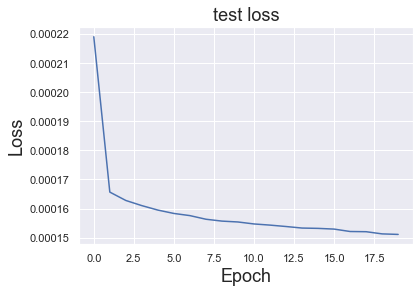

In [21]:
plt.figure()
plt.title("test loss", fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.plot(test_loss_list)

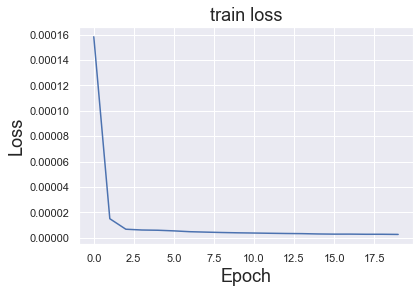

In [22]:
plt.figure()
plt.title("train loss", fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.plot(train_loss_list)

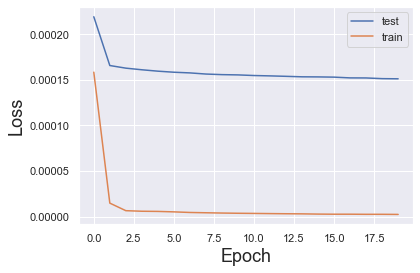

In [23]:
plt.figure()
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.plot(test_loss_list)
plt.plot(train_loss_list)
plt.legend(["test","train"])
#plt.savefig('loss.jpg', dpi=300, bbox_inches = 'tight')

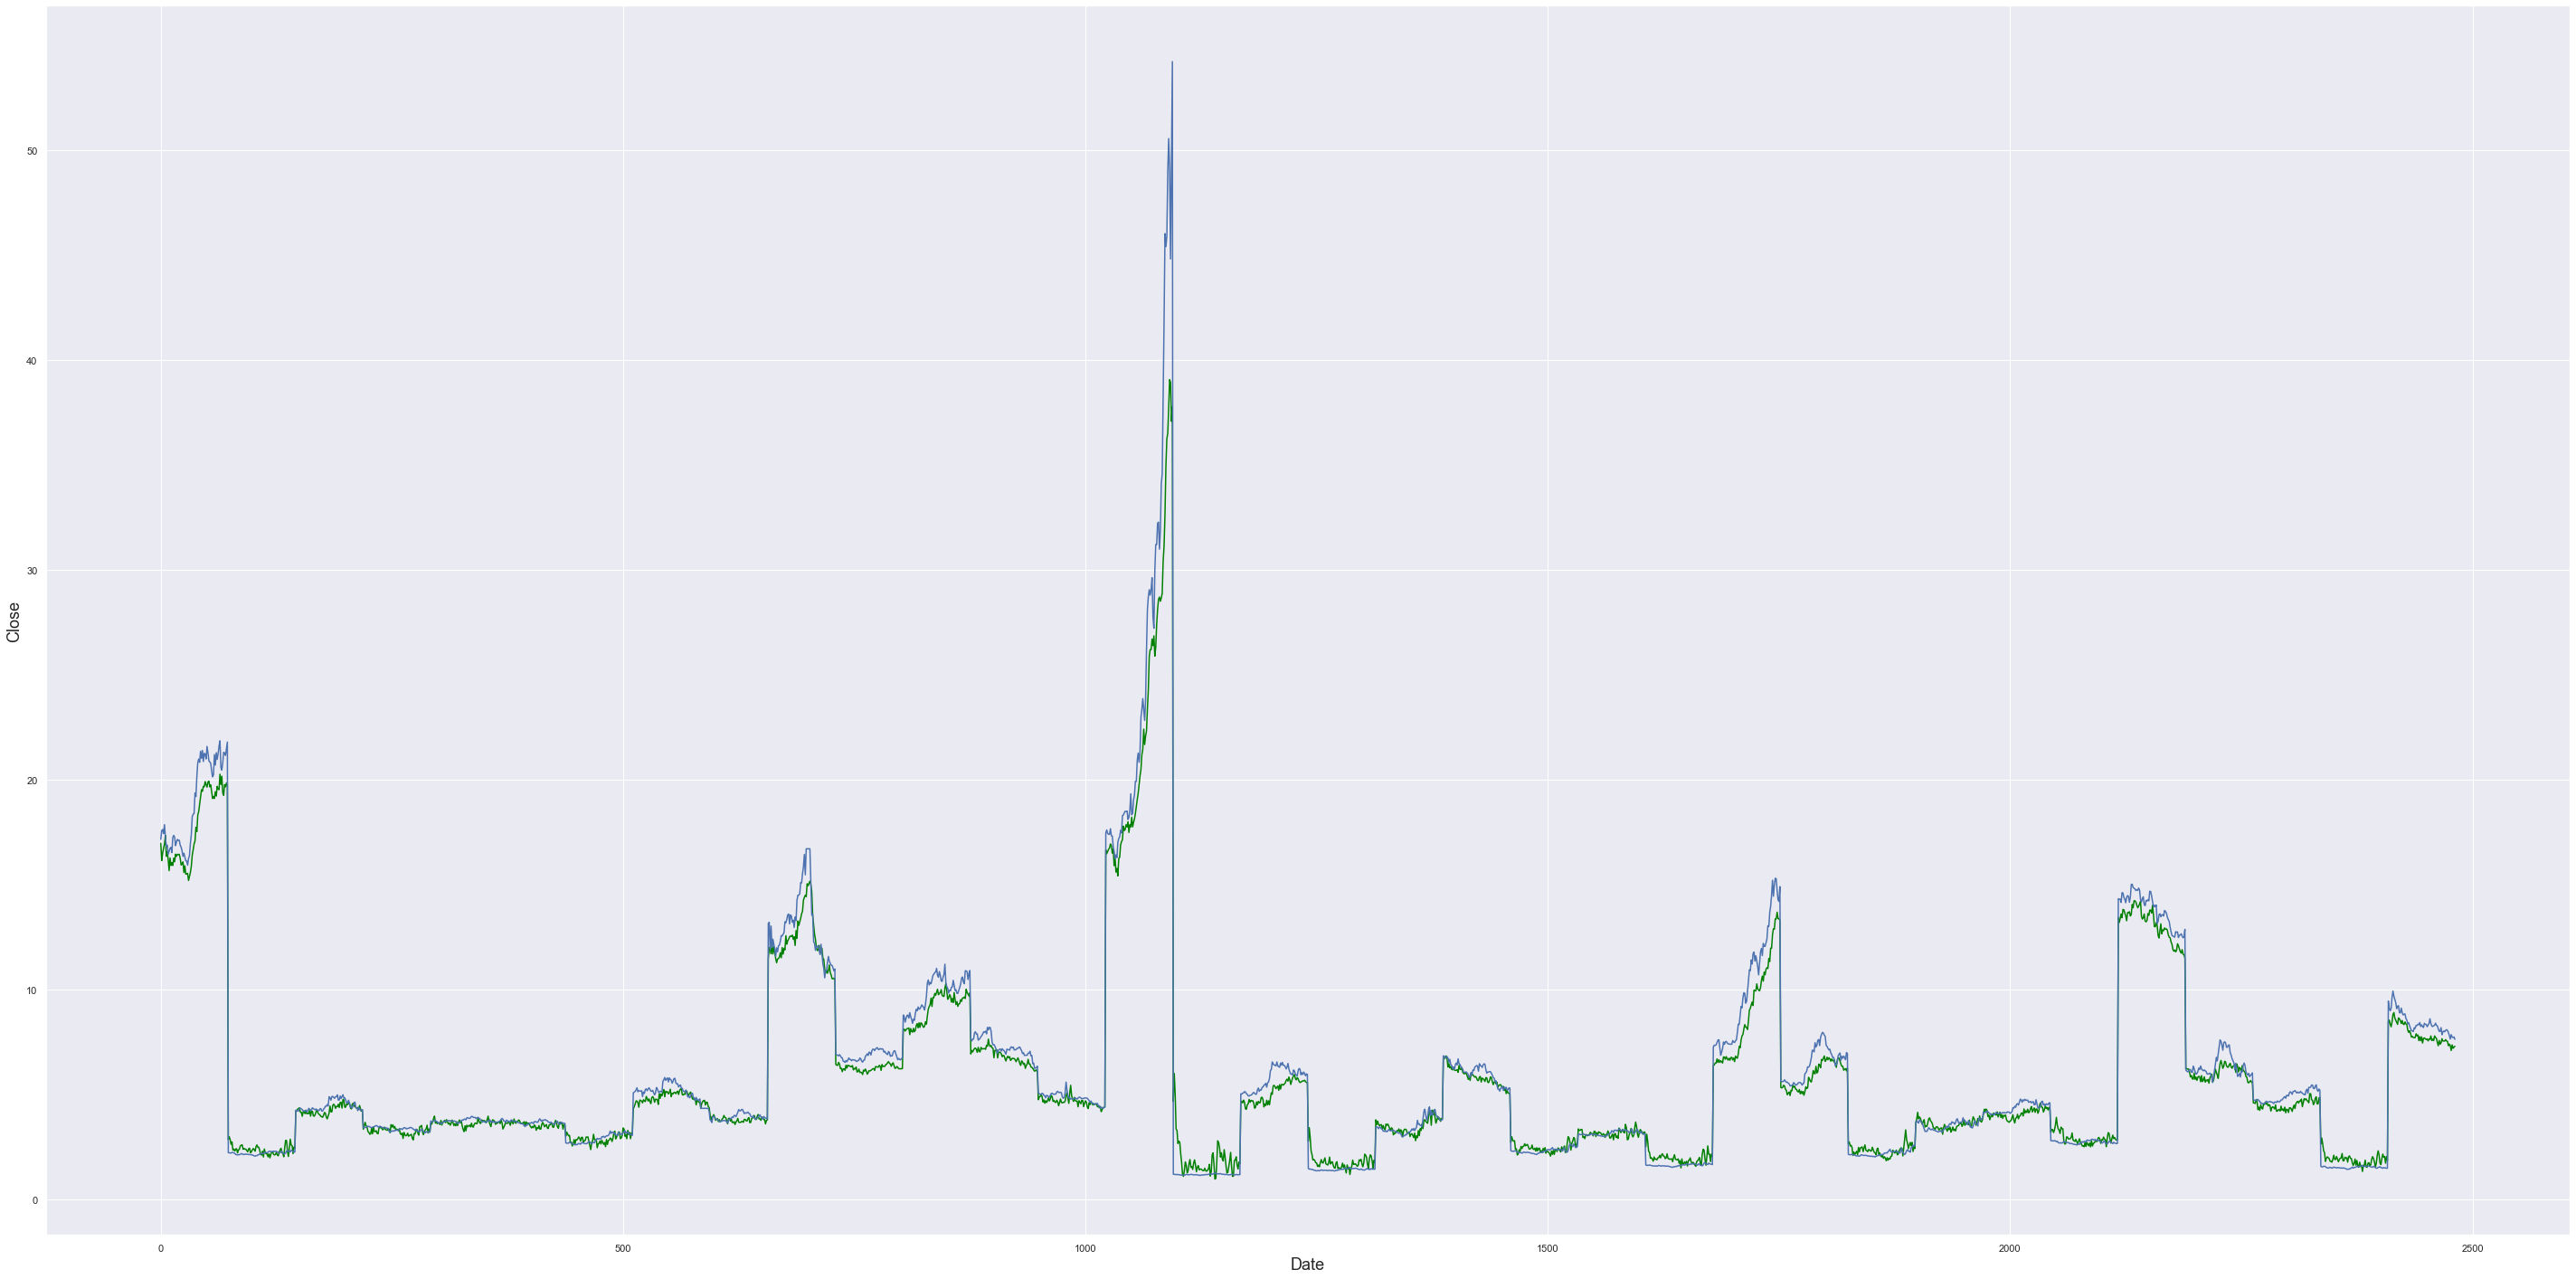

In [25]:
# 所有股票的测试结果
plot_img(data, pred)

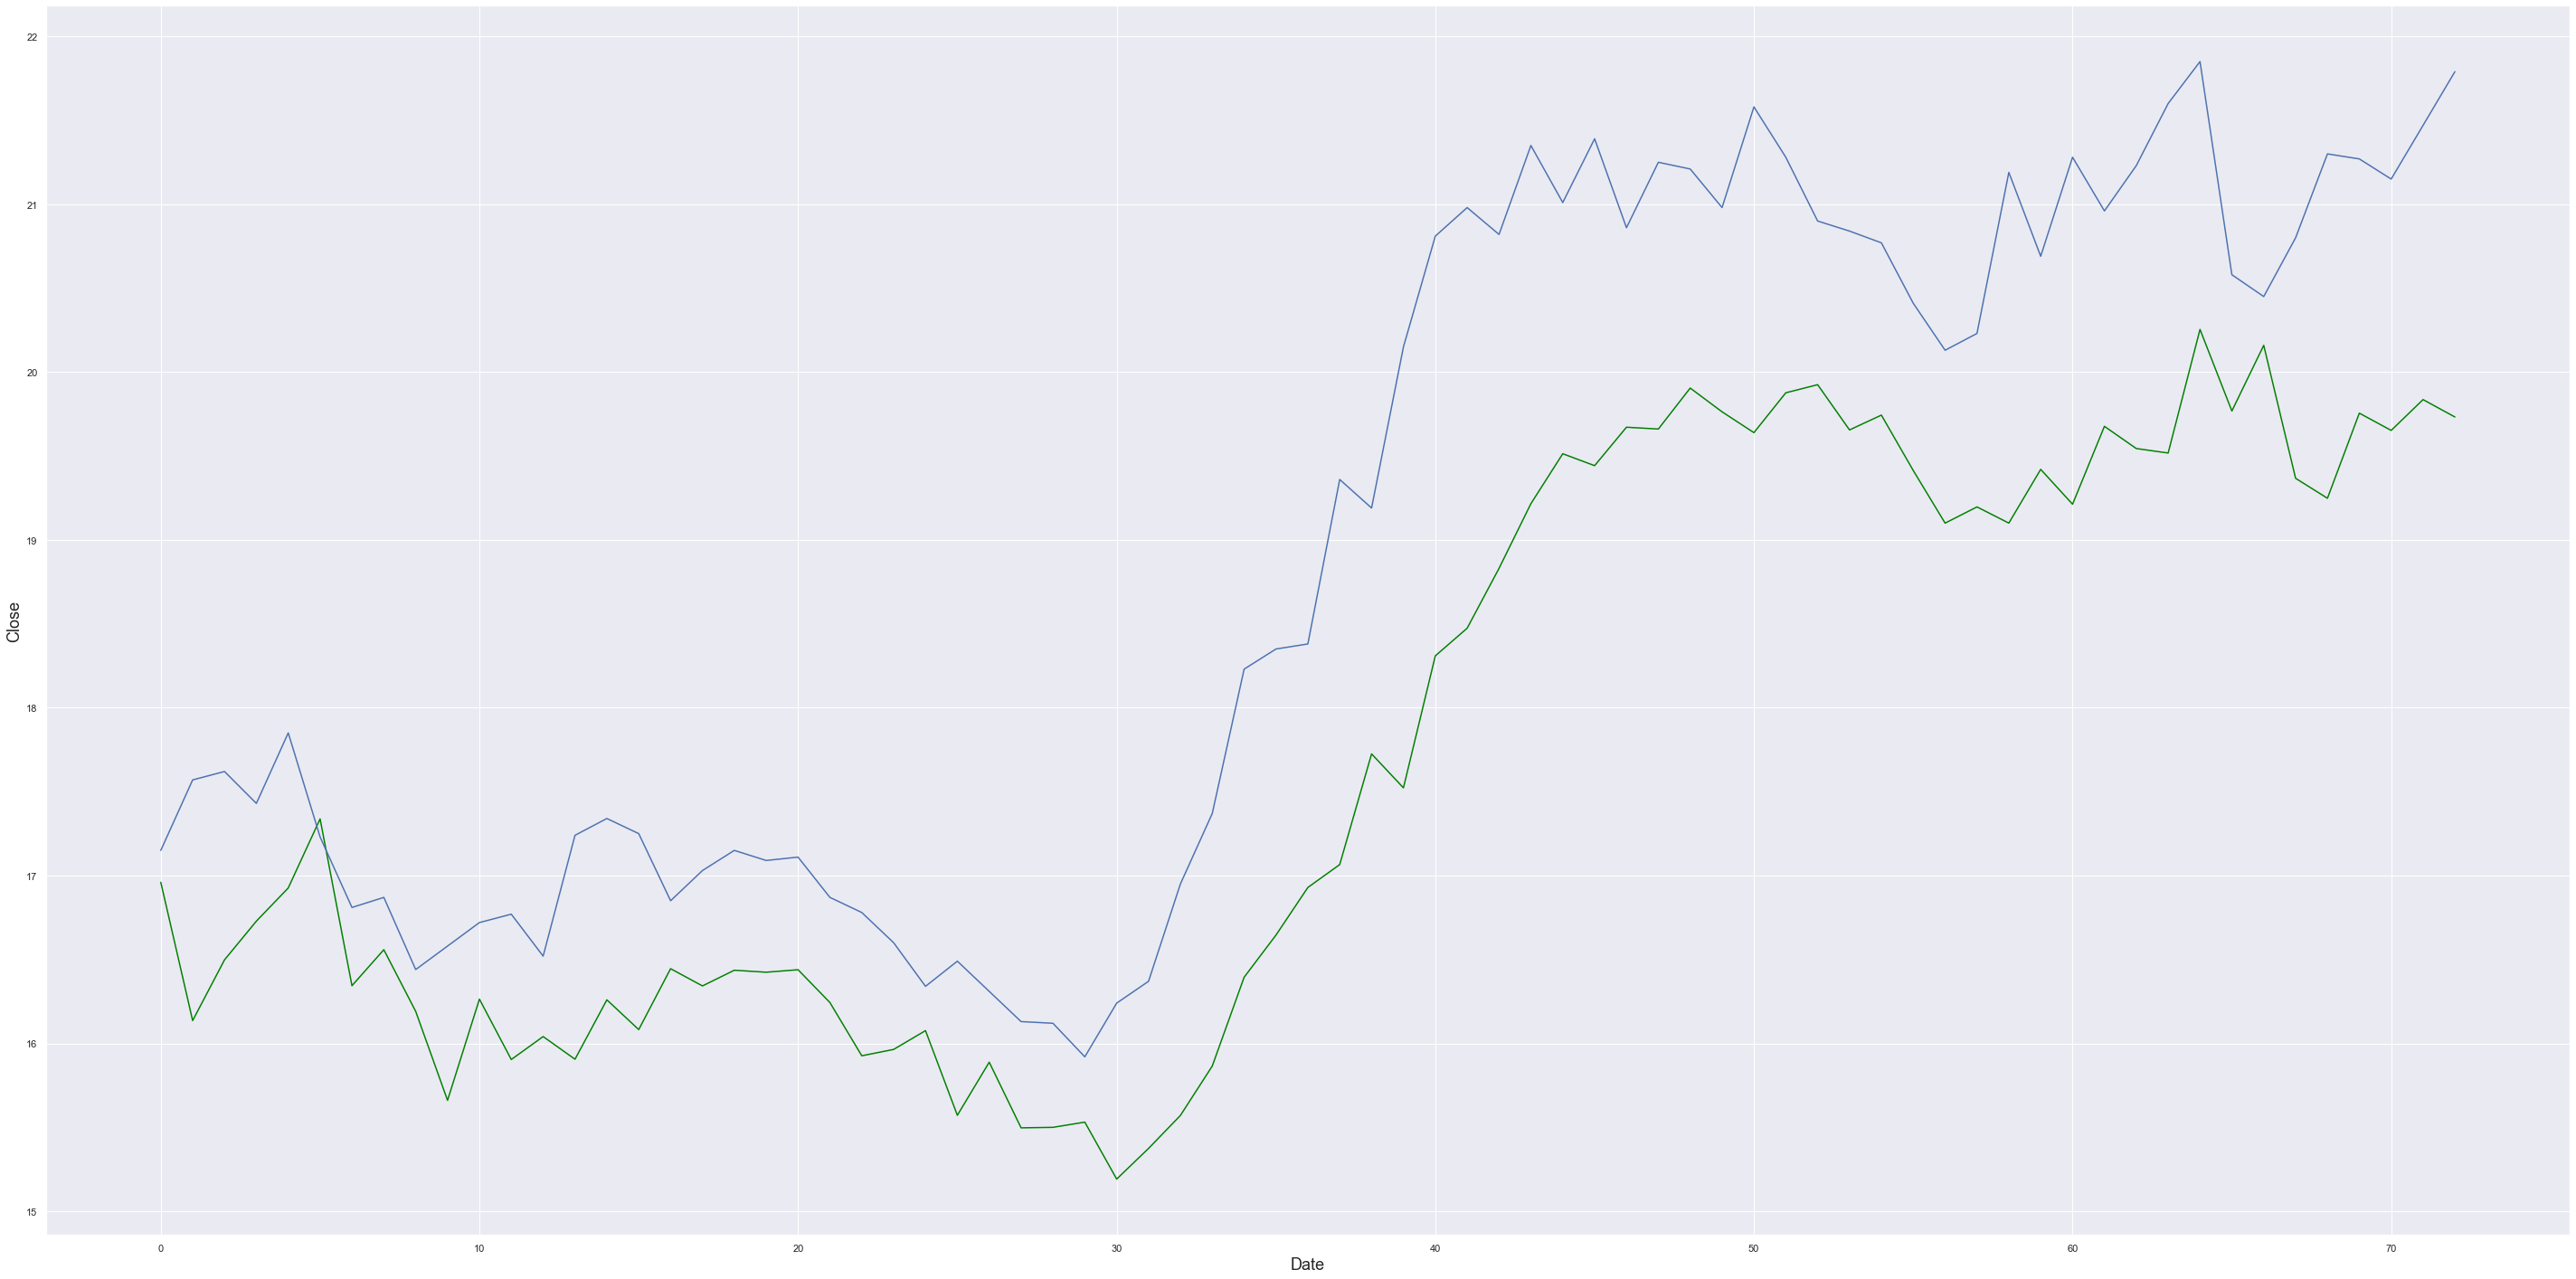

In [24]:
# 第一支股票的测试结果
plot_img(data[:73], pred[:73])